In [126]:
import torch
from torch.nn import PoissonNLLLoss
n_tasks = 10000
n_train = 40
lr = 0.05
max_steps = 10000
tol = 1e-10


In [189]:
def sample_data(n_tasks, n_points, d, ws = None, scale=0.32, loss_type="poisson", r=5):
    xs = torch.randn(n_tasks, n_points, d)
    if not isinstance(ws, torch.Tensor):
        ws = scale * torch.randn(n_tasks, d, 1)
    logits = xs @ ws
    mu = torch.exp(logits.clamp(max=4))  # shape: [n_tasks, n_points, 1]

    if loss_type == "poisson":
        ys = torch.poisson(mu).squeeze(-1)

    elif loss_type == "nb":
        # r is a scalar or float constant
        r_tensor = torch.tensor(r, dtype=mu.dtype, device=mu.device)
        logits_nb = torch.log(r_tensor) - torch.log(r_tensor + mu)
        dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, logits=logits_nb)
        ys = dist_nb.sample().squeeze(-1)

    else:
        raise ValueError(f"Unsupported data_type: {loss_type}. Use 'poisson' or 'neg_binomial'.")

    return xs, ys, ws

In [190]:
def nb_nll_loss(preds, targets, r=5):
    mu = torch.exp(preds)  
    r = torch.tensor(r, device=mu.device, dtype=mu.dtype)  
    logits = torch.log(r) - torch.log(r + mu)
    dist = torch.distributions.NegativeBinomial(total_count=r, logits=logits)
    return -dist.log_prob(targets)

def loss_func(loss):
    if loss == 'poisson':
        return PoissonNLLLoss(log_input=True, full=True, reduction='none')
    elif loss == 'nb':
        return nb_nll_loss



In [191]:
import torch
from torch.nn import PoissonNLLLoss
from tqdm import tqdm
import random


def run_oracle_on_random_context(context_len, n_tasks, d, lr, max_steps, tol, device="cuda", scale=0.32, loss_type="poisson", compare_loss=None):
    xs_all, ys_all, ws = sample_data(n_tasks, context_len, d, scale=scale, loss_type=loss_type)

    # Evaluate only at max context size (i.e., context_len - 1)
    t = context_len - 1
    xs_train = xs_all[:, :t, :].to(device)
    ys_train = ys_all[:, :t].to(device)
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)

    loss_fn = loss_func(loss_type)

    w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
    opt = torch.optim.Adam([w_hat], lr=lr)

    prev = float("inf")
    for step in range(1, max_steps + 1):
        logits = (xs_train @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred = logits
        loss = loss_fn(pred, ys_train).mean()
        
        l2_penalty = (0.5 / scale**2) * w_hat.pow(2).sum() / (n_tasks * t) 
        loss += l2_penalty
    
        
        if abs(prev - loss.item()) < tol:
            print(f"[Context {t}] Converged at step {step}")
            break
        prev = loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    else:
        print(f"[Context {t}] DID NOT converge (final Δloss={abs(prev - loss.item()):.2e})")

        
    with torch.no_grad():
        logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred_test = logits_test
        loss = loss_fn(pred_test, ys_test)
        print(loss_type, loss.mean().item(), loss.std().item())
        
    xs_all, ys_all, _ = sample_data(n_tasks, context_len, d, scale=scale, loss_type=compare_loss, ws=ws)
    t = context_len - 1
    xs_train = xs_all[:, :t, :].to(device)
    ys_train = ys_all[:, :t].to(device)
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)
    
    with torch.no_grad():
        logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred_test = logits_test
        comp_loss = loss_func(compare_loss)(pred_test, ys_test)
        print(compare_loss, comp_loss.mean().item(), comp_loss.std().item())

    
    
    return loss.mean().item()


device = "cuda" if torch.cuda.is_available() else "cpu"

run_oracle_on_random_context(context_len=40, n_tasks=10000, d=10, lr=0.05, max_steps=10000, 
                             tol=1e-10, scale=2, device=device, loss_type="nb", compare_loss="nb")

[Context 39] Converged at step 643
nb 2.237947940826416 1.6959385871887207
nb 2.229304552078247 1.6009730100631714


2.237947940826416

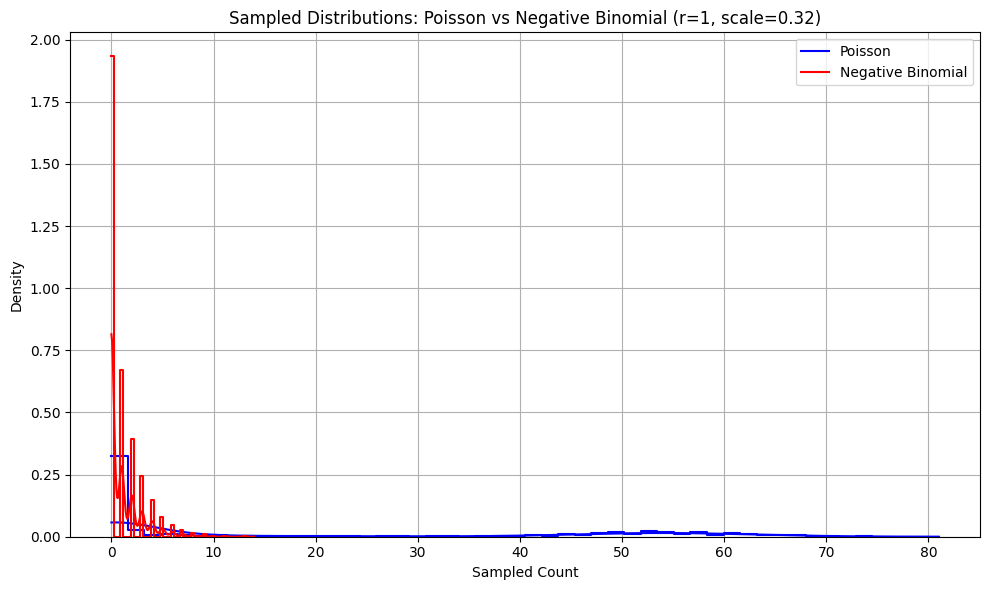

In [181]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def sample_and_plot_distributions(n_samples=10000, d=10, scale=2, r=2):
    # Generate random inputs
    xs = torch.randn(n_samples, d)
    ws = scale * torch.randn(d, 1)
    logits = xs @ ws
    mu = torch.exp(logits.clamp(max=4)).squeeze()

    # Sample from Poisson
    poisson_samples = torch.poisson(mu).cpu().numpy()

    # Sample from Negative Binomial
    r_tensor = torch.tensor(r, dtype=mu.dtype)
    logits_nb = torch.log(r_tensor) - torch.log(r_tensor + mu)
    dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, logits=logits_nb)
    nb_samples = dist_nb.sample().cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(poisson_samples, bins=50, color='blue', label='Poisson', stat='density', kde=True, element='step', fill=False)
    sns.histplot(nb_samples, bins=50, color='red', label='Negative Binomial', stat='density', kde=True, element='step', fill=False)
    plt.title("Sampled Distributions: Poisson vs Negative Binomial (r=1, scale=0.32)")
    plt.xlabel("Sampled Count")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run this in your own environment
sample_and_plot_distributions()
